In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [4]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [5]:
def dataset():
    num_outputs = 10
    validation_size = 5000
    batch_size = 32
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    train_labels = tf.keras.utils.to_categorical(train_labels,num_outputs)
    test_labels = tf.keras.utils.to_categorical(test_labels,num_outputs)
    
    validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
    train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
    
    def augment_images(image, label,input_size=(227,227), channel_first = False):
        # Normalize images to have a mean of 0 and standard deviation of 1
        # image = tf.image.per_image_standardization(image)
        # Resize images from 32x32 to 277x277
        image = tf.reshape(image, (28,28,1))
        # image = tf.image.grayscale_to_rgb(image, name=None)
        # image = tf.image.resize(image,input_size)
        if channel_first:
            image = tf.transpose(image, [2, 0, 1])

        return image, label



    train_ds_size = len(list(train_ds))
    test_ds_size = len(list(test_ds))
    validation_ds_size = len(list(validation_ds))

    print("trainSize {}".format(train_ds_size))
    print("testSize {}".format(test_ds_size))

    train_ds = (train_ds
                    .map(augment_images)
                    .shuffle(buffer_size=train_ds_size,seed=42,reshuffle_each_iteration=False)
                    .batch(batch_size=batch_size, drop_remainder=True))

    test_ds = (test_ds
                    # .map(augment_images)
                    #   .shuffle(buffer_size=train_ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))

    validation_ds = (validation_ds
                    # .map(augment_images)
                    #   .shuffle(buffer_size=validation_ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))

    return (train_ds, test_ds, validation_ds)

train_ds, test_ds, validation_ds = dataset()

trainSize 55000
testSize 10000


In [52]:
def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

def _KL(alpha, beta, K ):
    # print("K:",K)
    # beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    beta = tf.cast(beta,tf.float32)
    alpha = tf.cast(alpha,tf.float32)
    S_alpha = tf.reduce_sum(alpha,keepdims=True)
    S_beta = tf.reduce_sum(beta,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl



import tensorflow.python.keras.backend as K


current_epoch = K.variable(0.)
        
        
class changeAlpha(tf.keras.callbacks.Callback):
    def __init__(self):
        super(changeAlpha, self).__init__()
        self.current_epoch = current_epoch
    def on_epoch_begin(self, epoch, logs={}):

        K.set_value(self.current_epoch, epoch)
        tf.print("current epoch", K.get_value(current_epoch))

        
keras_kl = tf.keras.losses.KLDivergence()
        
        
def loss_wrapper2(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        tf.print("logits",logits)
        tf.print("E", E,summarize=-1)
        tf.print("p",p,summarize=-1)
        alp = E*(1-p) #+ 1 
        tf.print("alp",alp,summarize=-1)
        C =   annealing_coef * KL(alp,10)
        tf.print("C",C,summarize=-1)
        tf.print("loss", (A+B)+C)
        return (A + B) + C
    return custom_loss_function

def dirichlet_kl_divergence(alphas, target_alphas, precision=None, target_precision=None,
                            epsilon=1e-8):
    """
    This function computes the Forward KL divergence between a model Dirichlet distribution
    and a target Dirichlet distribution based on the concentration (alpha) parameters of each.
    :param alphas: Tensor containing concentation parameters of model. Expected shape is batchsize X num_classes.
    :param target_alphas: Tensor containing target concentation parameters. Expected shape is batchsize X num_classes.
    :param precision: Optional argument. Can pass in precision of model. Expected shape is batchsize X 1
    :param target_precision: Optional argument. Can pass in target precision. Expected shape is batchsize X 1
    :param epsilon: Smoothing factor for numercal stability. Default value is 1e-8
    :return: Tensor for Batchsize X 1 of forward KL divergences between target Dirichlet and model
    """
    # alphas = tf.cast(alphas,tf.float32)
    # print(alphas)
    # target_alphas = tf.cast(target_alphas,tf.float32)
    # print(target_alphas)
    if not precision:
        precision = tf.reduce_sum(alphas, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, keepdims=True)
    alpha_sum = tf.reduce_sum(alphas)
    # print(alpha_sum)
    target_alpha_sum = tf.reduce_sum(target_alphas)
    # print(target_alpha_sum)
    precision_term = tf.compat.v1.lgamma(tf.cast(target_precision,tf.float32)) - tf.compat.v1.lgamma(tf.cast(precision,tf.float32))
    
    # print(precision_term)
    # assert torch.all(torch.isfinite(precision_term)).item()
    # print(tf.reduce_sum(tf.compat.v1.lgamma(alpha_sum + epsilon) - tf.compat.v1.lgamma(target_alpha_sum + epsilon)))
    alphas_term = tf.reduce_sum(tf.compat.v1.lgamma(alpha_sum + epsilon) - tf.compat.v1.lgamma(target_alpha_sum + epsilon)
                            + (target_alpha_sum - alpha_sum) * (tf.compat.v1.digamma(target_alpha_sum + epsilon)- tf.compat.v1.digamma(target_precision + epsilon)), keepdims=True)
    alphas_term = tf.cast(alphas_term, tf.float32)
    # assert torch.all(torch.isfinite(alphas_term)).item()

    cost = tf.squeeze(precision_term +alphas_term )
    return cost


In [53]:
print("dkl",dirichlet_kl_divergence(np.array(.3),np.array(.5)))
print("dkl",dirichlet_kl_divergence(np.array(.5),np.array(.3)))
# dirichlet_kl_divergence([.3],[.5])

dkl tf.Tensor(2.9802322e-07, shape=(), dtype=float32)
dkl tf.Tensor(-2.9802322e-07, shape=(), dtype=float32)


In [54]:
K = 10
epsilon=1e-8
# alpha = np.array([.3,.3,.3,.3,.3,5,.3,.3,.3,.3])
alpha = np.array([0.1,1,1,1,1,1,1,1,1,1]) + epsilon
# alpha = np.array([0,0,0,0,0,0,0,0,0,1]) + epsilon
# alpha = np.array([0,0,0,0,0,0,0,0,0,0]) + epsilon
print(alpha)
beta=tf.constant(np.ones((1,K)),dtype=tf.double)
print(keras_kl(alpha,beta).numpy())

print(_KL(alpha,beta,K))
print(_KL(beta,alpha,K))
print("dkl",dirichlet_kl_divergence(alpha,beta))
print("dkl",dirichlet_kl_divergence(beta,alpha))

[0.10000001 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001
 1.00000001 1.00000001 1.00000001 1.00000001]
-0.2302585244178772
tf.Tensor([[7.0831804]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.6892166]], shape=(1, 1), dtype=float32)
dkl tf.Tensor(4.7683716e-07, shape=(), dtype=float32)
dkl tf.Tensor(-4.7683716e-07, shape=(), dtype=float32)


In [68]:
print(keras_kl(np.array(.3),np.array(.5)).numpy())
print(keras_kl(np.array(.3),np.array(.5)).numpy())

print(_KL(np.array(.3),np.array(.5)))
# tf.reduce_sum([.3],keepdims=True)

InvalidArgumentError: Invalid reduction dimension (-1 for input with 0 dimension(s) [Op:Sum]

In [57]:
def dirichlet_kl_divergence(alpha_c_target, alpha_c_pred, eps=10e-10):
    tf.print(alpha_c_target)
    tf.print(tf.argmax(alpha_c_pred, axis=-1))
    alpha_0_target = tf.reduce_sum(alpha_c_target, axis=-1, keepdims=True)
    alpha_0_pred = tf.reduce_sum(alpha_c_pred, axis=-1, keepdims=True)

    tf.print(tf.math.lgamma(alpha_0_pred))
    tf.print(tf.math.lgamma(alpha_0_target))

    tf.print(tf.math.lgamma(alpha_c_pred + eps))
    tf.print(tf.math.lgamma(alpha_c_target + eps))

    tf.print(tf.math.digamma(alpha_c_pred + eps))
    tf.print(tf.math.digamma(alpha_c_target + eps))

    term1 = tf.math.lgamma(alpha_0_target) - tf.math.lgamma(alpha_0_pred)
    term2 = tf.math.lgamma(alpha_c_pred + eps) - tf.math.lgamma(alpha_c_target + eps)

    term3_tmp = tf.math.digamma(alpha_c_target + eps) - tf.math.digamma(alpha_0_target + eps)
    term3 = (alpha_c_target - alpha_c_pred) * term3_tmp

    result = tf.squeeze(term1 + tf.reduce_sum(term2 + term3, keepdims=True, axis=-1))

    return result
alpha = np.array([0.1,1,1,1,1,1,1,1,1,1])
# alpha = np.array([0,0,0,0,0,0,0,0,0,1]) + epsilon
# alpha = np.array([0,0,0,0,0,0,0,0,0,0]) + epsilon
beta=tf.constant(np.ones((1,K)),dtype=tf.double)
dirichlet_kl_divergence(alpha,beta)
dirichlet_kl_divergence(beta,alpha)

array([0.1, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])
[0]
[[12.801827480081473]]
[10.819252325110432]
[[-5.77216496822075e-10 -5.77216496822075e-10 -5.77216496822075e-10 ... -5.77216496822075e-10 -5.77216496822075e-10 -5.77216496822075e-10]]
[2.2527126413104517 -5.77216496822075e-10 -5.77216496822075e-10 ... -5.77216496822075e-10 -5.77216496822075e-10 -5.77216496822075e-10]
[[-0.577215663256599 -0.577215663256599 -0.577215663256599 ... -0.577215663256599 -0.577215663256599 -0.577215663256599]]
[-10.423754838977779 -0.577215663256599 -0.577215663256599 ... -0.577215663256599 -0.577215663256599 -0.577215663256599]
[[1 1 1 ... 1 1 1]]
1
[10.819252325110432]
[[12.801827480081473]]
[2.2527126413104517 -5.77216496822075e-10 -5.77216496822075e-10 ... -5.77216496822075e-10 -5.77216496822075e-10 -5.77216496822075e-10]
[[-5.77216496822075e-10 -5.77216496822075e-10 -5.77216496822075e-10 ... -5.77216496822075e-10 -5.77216496822075e-10 -5.77216496822075e-10]]
[-10.423754838977779 -0.57721566325

<tf.Tensor: shape=(), dtype=float64, numpy=1.6892163696730713>

In [5]:
batch_size = 128
epochs = 15

# model = keras.Sequential(
#     [
#         keras.Input(shape=input_shape),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes),
#     ]
# )


#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def evidence_crossentropy(annealing_rate=1, momentum=1, decay=1, global_loss=False,num_outputs=10):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = tf.nn.softplus(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print("A+B",(A+B).shape, tf.reduce_sum(A+B, axis=1))
        # annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_rate * KL(alp,num_outputs)
        # print("c",C)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        # tf.print("loss",loss.shape,loss)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

# model.compile(loss=loss_wrapper(current_epoch), optimizer="adam", metrics=["accuracy"])
# model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
# model.fit(train_ds, epochs=epochs,callbacks = [changeAlpha()])

In [6]:
#entropy train, without KL divergence
loss_fn = evidence_crossentropy()
# loss_fn = loss_wrapper(1)
model.compile(loss=loss_fn, optimizer="adam", metrics=["accuracy"])
model.fit(train_ds, epochs=15)

Epoch 1/15
 912/1718 [==============>...............] - ETA: 2s - loss: 1.0578 - accuracy: 0.8404

KeyboardInterrupt: 

prob [[2.0098687e-09 9.9995768e-01 5.8973870e-07 2.2073839e-07 7.3820083e-06
  5.6227524e-08 3.2323888e-07 1.4429465e-08 3.3508823e-05 2.2549921e-07]]
u 0.0007158307 prob 1.0
0.0007158307
prob [[5.1648762e-13 9.9967396e-01 4.8271448e-07 3.7269022e-06 1.5308214e-07
  2.5593915e-08 2.3595416e-11 1.5768457e-09 3.2099549e-04 6.3854094e-07]]
u 0.004290136 prob 1.0
0.004290136
prob [[7.8678860e-12 7.9598093e-01 2.4097511e-05 6.6517125e-04 6.8474505e-06
  2.0613984e-04 3.2422616e-08 2.2774987e-08 2.0306323e-01 5.3554519e-05]]
u 0.7398702 prob 1.0
0.7398702
prob [[6.5522965e-10 8.7491803e-02 2.0123117e-04 8.5789484e-01 1.0307705e-03
  3.2894041e-02 2.6358558e-07 9.4711443e-04 1.9539788e-02 1.5602086e-07]]
u 0.7924057 prob 1.0
0.7924057
prob [[1.3007619e-07 6.8192473e-03 1.4950720e-02 1.4108554e-01 4.9578565e-01
  3.3049050e-01 7.4449014e-07 8.3173299e-03 2.5494208e-03 7.1118654e-07]]
u 1.6475515 prob 1.0
1.6475515
prob [[6.83626695e-07 1.04587298e-05 1.17498465e-04 4.54616857e-05
  1.47710647e

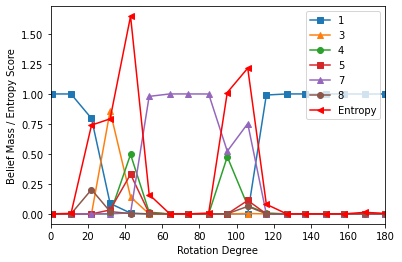

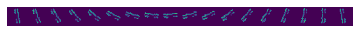

[0.0007158307, 0.004290136, 0.7398702, 0.7924057, 1.6475515, 0.16179925, 0.0018507784, 0.00012426858, 0.0070279413, 1.0118821, 1.2147199, 0.080270365, 4.3697386e-05, 0.00063371635, 1.8385658e-06, 0.00034595307, 0.013234742, 0.00406214]


In [22]:
rotate_img_entropy()

In [11]:

#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=(227,227,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function


def metric_wrapper(annealing_coef):
    def detailed_losses(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (tf.reduce_sum(A+B), tf.reduce_sum(C)) # Note the `axis=-1`
    return detailed_losses

# #example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
# for i in range(4):
#     print("annealing_coef:", tf.minimum(1,tf.cast(i/10,tf.float32)))
#     # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
#     model.compile(loss=loss_wrapper(0), optimizer="adam", metrics=["accuracy", detailed_losses])
#     model.fit(train_ds,epochs = 1)
    

In [39]:
# model = keras.Sequential(
#     [
#         keras.Input(shape=(28,28,1)),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes),
#     ]
# )
# model.save("./models/mnist_blank.hdf5")

In [41]:

#entropy version



def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        # tf.print(tf.reduce_sum(A+B), tf.reduce_sum(C))
        
        return (A + B) + C
    return custom_loss_function

crossentropy = tf.keras.losses.CategoricalCrossentropy()
def lossMetric(annealing_coef):
    def lossMetric(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.softplus(logits)
        loss = crossentropy(p, evidence)
          
#         alpha = evidence + 1

#         S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
#         E = alpha - 1
#         m = alpha / S
#         A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
#         B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
#         # tf.print(annealing_coef)
#         # annealing_coef = 

#         alp = E*(1-p) + 1 
#         C =   annealing_coef * KL(alp,10)
        return (loss) # Note the `axis=-1`
    return lossMetric

def klMetric(annealing_coef):
    def klMetric(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        # tf.print(logits)
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (tf.reduce_mean(C)) # Note the `axis=-1`
    return klMetric

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))


# def loss_EDL(annealing):
#     beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
    
#     def loss_func(p, logits): 
#         func=tf.compat.v1.digamma
#         E = tf.nn.softplus(logits)
#         alpha = E + 1
#         S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
#         # E = alpha - 1
    
#         A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
#         # annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))
#         # beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
        
#         alp = E*(1-p) + 1 
        
#         B =  annealing * KL(alp,10)
    
#         return (A + B)
#     return loss_func

crossentropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def loss_EDL(annealing):
    def loss_func(p, logits): 
        
        func=tf.compat.v1.digamma
        E = tf.nn.softplus(logits)
        # tf.print("E", E,summarize=-1)
        alpha = E + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        # E = alpha - 1
    
        A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
        CE = tf.minimum(1.0, tf.cast(1-annealing, tf.float32)) * crossentropy(p, logits)
        # annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))
        
        alp = E*(1-p) + 1 
        
        B =  annealing * KL(alp,10)
    
        return (A + B + CE)
    return loss_func
model = tf.keras.models.load_model("./models/mnist_blank.hdf5")
#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(10):
    # if i > 5:
    annealing = tf.minimum(1,tf.cast((i)/10,tf.float32))
    # annealing = 0
    
    # else:
        # annealing = 0
    print("annealing_coef:", annealing)
    # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.compile(loss=loss_EDL(annealing), optimizer="adam", metrics=["accuracy",lossMetric(annealing),klMetric(annealing)])
    model.fit(train_ds,epochs = 1)
    
    

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1718/1718 [==============================] - 9s 5ms/step - loss: 1.2988 - accuracy: 0.9212 - lossMetric: 0.5861 - klMetric: 0.0000e+00
annealing_coef: tf.Tensor(0.1, shape=(), dtype=float32)
1718/1718 [==============================] - 9s 5ms/step - loss: 0.7182 - accuracy: 0.9690 - lossMetric: 0.2268 - klMetric: 0.0601
annealing_coef: tf.Tensor(0.2, shape=(), dtype=float32)
1718/1718 [==============================] - 9s 5ms/step - loss: 0.6286 - accuracy: 0.9768 - lossMetric: 0.1980 - klMetric: 0.0695
annealing_coef: tf.Tensor(0.3, shape=(), dtype=float32)
1718/1718 [==============================] - 10s 5ms/step - loss: 0.5673 - accuracy: 0.9802 - lossMetric: 0.1838 - klMetric: 0.0733
annealing_coef: tf.Tensor(0.4, shape=(), dtype=float32)
1718/1718 [==============================] - 9s 5ms/step - loss: 0.5272 - accuracy: 0.9822 - lossMetric: 0.1745 - klMetric: 0.0781
annealing_coef: tf.Tensor(0.5, shape=(), dtype=float32)
1718

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


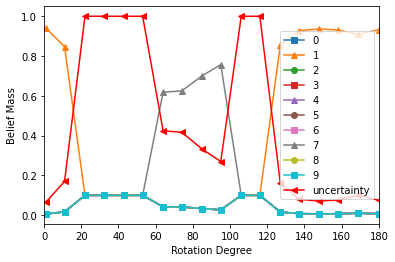

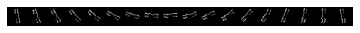

In [42]:
# pred = model.predict(tf.reshape(digit_one,(1,28,28)))
# print(pred, tf.nn.softplus(pred))

# Crossentropy + KL(0)
import matplotlib.pyplot as plt
digit_one = x_train[6]
rotate = rotateImg(model,digit_one,False)

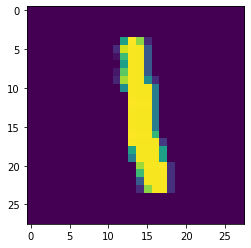

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


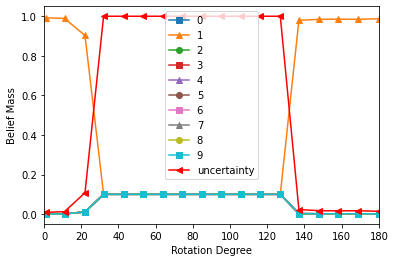

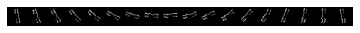

[0.008877139,
 0.012183519,
 0.10790125,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.022756403,
 0.017305871,
 0.016287172,
 0.017090281,
 0.013950982]

In [19]:
# pred = model.predict(tf.reshape(digit_one,(1,28,28)))
# print(pred, tf.nn.softplus(pred))

# Crossentropy + KL(.1)
import matplotlib.pyplot as plt
digit_one = x_train[6]
plt.imshow(digit_one)
plt.show()
rotate = rotateImg(model,digit_one,False)

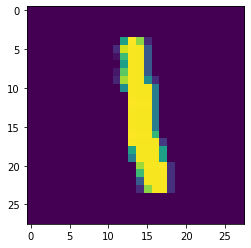

[[-140.71185   144.69887  -114.95169  -107.92407   -95.94248  -132.06491
  -101.93563  -105.75596   -60.697247 -126.180756]] tf.Tensor(
[[0.0000000e+00 1.4469887e+02 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 4.3603443e-27 0.0000000e+00]], shape=(1, 10), dtype=float32) label 1
[[-188.95105    86.52791   -56.294678  -64.62409   -83.48349  -120.46764
  -132.90417  -125.83447   -63.31691   -86.34827 ]] tf.Tensor(
[[0.0000000e+00 8.6527908e+01 3.5606731e-25 8.5923788e-29 5.5409086e-37
  0.0000000e+00 0.0000000e+00 0.0000000e+00 3.1755246e-28 3.1580887e-38]], shape=(1, 10), dtype=float32) label 1
[[-207.4374     16.32435   -49.96603   -26.138514  -97.59052   -71.653
  -144.81845   -97.25423   -51.941135 -152.62595 ]] tf.Tensor(
[[0.0000000e+00 1.6324350e+01 1.9953949e-22 4.4482356e-12 0.0000000e+00
  7.6119783e-32 0.0000000e+00 0.0000000e+00 2.7685446e-23 0.0000000e+00]], shape=(1, 10), dtype=float32) label 1
[[-180.12003   -43.493     -37.124866  

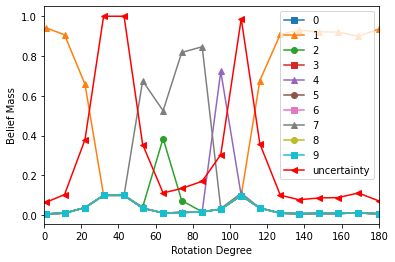

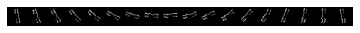

[0.064641714,
 0.103596985,
 0.37987643,
 1.0,
 1.0,
 0.35529894,
 0.1116471,
 0.13456525,
 0.1703332,
 0.3041415,
 0.98770565,
 0.35922042,
 0.10080785,
 0.07779391,
 0.08675471,
 0.088400945,
 0.11170628,
 0.07168851]

In [17]:
# pred = model.predict(tf.reshape(digit_one,(1,28,28)))
# print(pred, tf.nn.softplus(pred))
import matplotlib.pyplot as plt
digit_one = x_train[6]
plt.imshow(digit_one)
plt.show()
rotateImg(model,digit_one,True)

In [55]:
print(tf.nn.softplus(-50.0))

tf.Tensor(1.9287499e-22, shape=(), dtype=float32)


[[-647.7345   696.4308  -979.0093  -722.8716  -793.7095  -830.4821
  -726.825   -666.07495 -361.5338  -563.43036]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


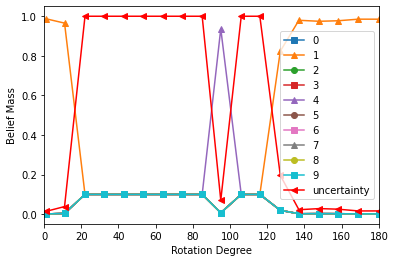

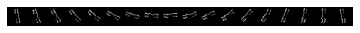

[0.014155668,
 0.038520016,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.07063323,
 1.0,
 1.0,
 0.19625838,
 0.022649346,
 0.02831071,
 0.02538067,
 0.016398367,
 0.01655108]

In [43]:
print((model.predict(tf.reshape(digit_one,(1,28,28)))))
rotateImg(model)

In [13]:
def rotateImg(model, digit_one, verbose=False):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        if verbose:
            print(_pred, tf.nn.softplus(_pred), "label", np.argmax(_pred))
        evidence = tf.nn.softplus(_pred)
        alpha = evidence + 1
        u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        # print("prob", evidence)
        # print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        # print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)

    print(labels)
    for j in range(len(labels)):
        plt.plot(ldeg,lp[:,j],marker=marker[j])
    labels += ['uncertainty']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass')
    # plt.yscale("log")
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    return(uncert)

In [31]:
def rotateImg(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        evidence = tf.nn.softplus(_pred)
        alpha = evidence + 1
        u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        # print("prob", evidence)
        # print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        # print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)

    print(labels)
    for j in range(len(labels)):
        plt.plot(ldeg,lp[:,j],marker=marker[j])
    labels += ['uncertainty']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass')
    # plt.yscale("log")
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    return(uncert)

In [ ]:
model.evaluate(test_ds)

In [16]:

#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function



#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(4):
    print("annealing_coef:", tf.minimum(1,tf.cast(i/10,tf.float32)))
    annealing = tf.minimum(1,tf.cast(i/10,tf.float32))
    model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    # model.compile(loss=evidence_crossentropy(annealing), optimizer="adam", metrics=["accuracy"])
    model.fit(train_ds,epochs = 1)
    

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1718/1718 [==============================] - 10s 5ms/step - loss: 0.1313 - accuracy: 0.9218
annealing_coef: tf.Tensor(0.1, shape=(), dtype=float32)
1718/1718 [==============================] - 9s 5ms/step - loss: 0.1344 - accuracy: 0.9647
annealing_coef: tf.Tensor(0.2, shape=(), dtype=float32)
1718/1718 [==============================] - 9s 4ms/step - loss: 0.1482 - accuracy: 0.9674
annealing_coef: tf.Tensor(0.3, shape=(), dtype=float32)
1718/1718 [==============================] - 11s 6ms/step - loss: 0.1608 - accuracy: 0.9695


1


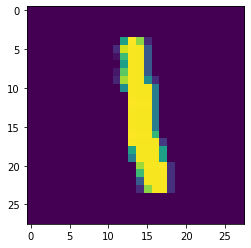

In [123]:
import matplotlib.pyplot as plt
digit_one = x_train[6]

print(np.argmax(model.predict(digit_one.reshape(1,28,28))))
plt.imshow(digit_one.reshape(28,28)) 
plt.show()

In [135]:
def rotate_img_crossevidence(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
    #     print(_pred)
        # evidence = tf.nn.relu(_pred)
        evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1


        # evidence = tf.nn.relu(_pred)
        # alpha = evidence + 1

        u = tf.reduce_sum(evidence, axis=1, keepdims=True) #uncertainty

        # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        print("prob", evidence)
        print("u", u.numpy(), "prob",tf.reduce_sum(evidence).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += evidence.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(evidence[0])
        print(u.numpy())
        pred.append(pred)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels",labels)
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    for j in range(len(labels)):
        print(labels[j])
        print(lp)
        y =[]
        for i in range(len(lp)):
            y.append(lp[i][j])


        plt.plot(ldeg,y,marker=marker[j])



    labels += ['Entropy']
    plt.plot(ldeg,uncert,marker='<',ls='--',c='red',zorder=0)

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Predicted Probability')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

prob tf.Tensor(
[[6.5535186e-13 1.8844068e-01 2.7934789e-07 1.1621394e-08 5.5195746e-09
  2.8452870e-11 4.5765403e-10 7.9887830e-09 5.2179043e-06 1.9766713e-10]], shape=(1, 10), dtype=float32)
u [[0.18844621]] prob 0.18844621
[[0.18844621]]
prob tf.Tensor(
[[3.61930054e-24 5.23236622e-07 1.17731085e-11 3.07065673e-14
  5.92468445e-18 6.72315817e-18 3.69096184e-19 2.82275813e-14
  1.58854082e-12 8.14536661e-17]], shape=(1, 10), dtype=float32)
u [[5.2325004e-07]] prob 5.2325004e-07
[[5.2325004e-07]]
prob tf.Tensor(
[[1.0103113e-21 6.2338011e-05 2.7430216e-11 2.7323128e-14 1.9854088e-16
  1.5509566e-14 1.6467396e-17 5.1948827e-16 7.6999594e-13 1.6310468e-18]], shape=(1, 10), dtype=float32)
u [[6.233804e-05]] prob 6.233804e-05
[[6.233804e-05]]
prob tf.Tensor(
[[1.66884962e-15 1.13744164e-07 3.11397501e-12 1.51806831e-11
  7.54755850e-13 8.48355674e-12 1.99233008e-14 5.89834171e-12
  5.62279390e-13 5.99075434e-17]], shape=(1, 10), dtype=float32)
u [[1.1377818e-07]] prob 1.1377818e-07
[[1.13

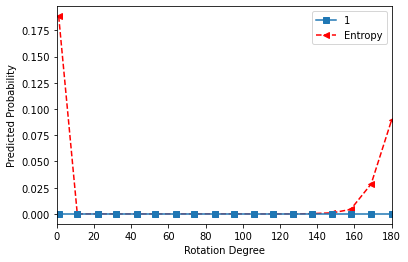

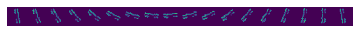

[0.18844621, 5.2325004e-07, 6.233804e-05, 1.1377818e-07, 9.085725e-11, 1.1687073e-08, 5.7493697e-05, 2.9753628e-05, 9.05475e-05, 7.244954e-05, 7.7653635e-09, 1.6452828e-10, 3.8197495e-06, 0.00027558542, 0.0010198655, 0.004291958, 0.028569005, 0.08956691]


In [136]:
rotate_img_crossevidence(model)

prob tf.Tensor(
[[6.5535186e-13 1.8844068e-01 2.7934789e-07 1.1621394e-08 5.5195746e-09
  2.8452870e-11 4.5765403e-10 7.9887830e-09 5.2179043e-06 1.9766713e-10]], shape=(1, 10), dtype=float32)
u [[0.98150396]] prob 1.0
[[0.98150396]]
prob tf.Tensor(
[[3.61930054e-24 5.23236622e-07 1.17731085e-11 3.07065673e-14
  5.92468445e-18 6.72315817e-18 3.69096184e-19 2.82275813e-14
  1.58854082e-12 8.14536661e-17]], shape=(1, 10), dtype=float32)
u [[1.]] prob 1.0000001
[[1.]]
prob tf.Tensor(
[[1.0103113e-21 6.2338011e-05 2.7430216e-11 2.7323128e-14 1.9854088e-16
  1.5509566e-14 1.6467396e-17 5.1948827e-16 7.6999594e-13 1.6310468e-18]], shape=(1, 10), dtype=float32)
u [[0.9999937]] prob 0.9999999
[[0.9999937]]
prob tf.Tensor(
[[1.66884962e-15 1.13744164e-07 3.11397501e-12 1.51806831e-11
  7.54755850e-13 8.48355674e-12 1.99233008e-14 5.89834171e-12
  5.62279390e-13 5.99075434e-17]], shape=(1, 10), dtype=float32)
u [[1.]] prob 1.0000001
[[1.]]
prob tf.Tensor(
[[2.2831786e-16 5.1840771e-11 3.6141695e

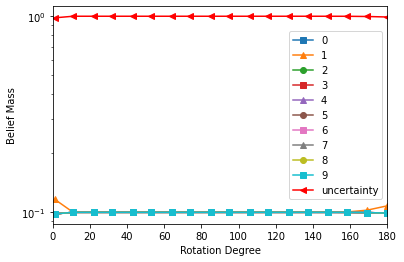

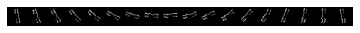

[0.98150396, 1.0, 0.9999937, 1.0, 1.0, 1.0, 0.9999943, 0.999997, 0.99999094, 0.9999927, 1.0, 1.0, 0.99999964, 0.99997246, 0.9998981, 0.999571, 0.9971512, 0.9911228]


In [124]:
import tensorflow_addons as tfa
linspace = np.linspace(1,180,num=18)
digit_one = x_train[6]
import matplotlib.pyplot as plt
Mdeg = 180 
Ndeg = int(Mdeg/10)+1
K = 10
# print(linspace)
pred = []
uncert = []
label = []
answer = []
ldeg = []
lp = []
lu=[]
scores = np.zeros((1,K))
threshold = 0.001
Results = pd.DataFrame()
rimgs = []
K=10
from PIL import Image

for i in linspace:
    i = int(i)
    radians = i* np.pi/180
    # print(radians)
    rotate = tfa.image.rotate(digit_one, tf.constant(radians))
    rimg = rotate
    rimgs.append(rimg.numpy().reshape(28,28))
#     rimgs.append(rotate)
    _pred=model.predict(tf.reshape(rotate,(1,28,28)))
#     print(_pred)
    # evidence = tf.nn.relu(_pred)
    evidence = tf.nn.softplus(_pred)
    # alpha = evidence + 1
    
    
    # evidence = tf.nn.relu(_pred)
    alpha = evidence + 1

    u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty

    prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
    print("prob", evidence)
    print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
    # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
    # prob = evidence/tf.reduce_sum(evidence, 1) 
#     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
    scores += prob.numpy().astype("float") >= threshold
#     print("scores",scores)
    lp.append(prob[0])
    print(u.numpy())
    pred.append(prob)
    uncert.append(u.numpy().mean())
    label.append(1)
    answer.append(np.argmax(_pred))
    ldeg.append(i)
labels = np.arange(10)[scores[0].astype(bool)]
# print("labels",labels)
lp = np.array(lp)[:,labels]
# c = ['black','blue','red','brown','purple','cyan']
marker = ['s','^','o']*4
labels = labels.tolist()
# print("lp",lp)

print(labels)
for j in range(len(labels)):
    # print(lp[:,j], answer[j])
    
    
    plt.plot(ldeg,lp[:,j],marker=marker[j])
    


labels += ['uncertainty']
plt.plot(ldeg,uncert,marker='<',c='red')

plt.legend(labels)
 
plt.xlim([0,Mdeg])  
plt.xlabel('Rotation Degree')
plt.ylabel('Belief Mass')
plt.yscale("log")
plt.show()

img = Image.new('L', (28*len(rimgs), 28))
x_offset =0
for im in rimgs:
#     print(im)
    _im = Image.fromarray(np.uint8((im)*255))
    img.paste(_im,(x_offset,0))
    x_offset += _im.size[0]
    
plt.figure(figsize=[6.2,100])
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()
#     print(pred, np.argmax(pred))
#     _ = plt.imshow(rotate)
#     plt.show()
print(uncert)

In [102]:
def rotate_img_entropy():
    def calcEntropy_Tensors2(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #doesn't deal with cases of log(0)
        val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        return -sumEntropies

    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.2
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        prob = _pred
        # evidence = tf.nn.relu(_pred)
        # evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1
        
        u = calcEntropy_Tensors2(prob)
        print("prob", _pred)
        print("u", tf.reduce_sum(u).numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += _pred.astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    print(labels)
    for j in range(len(labels)):
        print(lp[:,j], answer[j])


        plt.plot(ldeg,lp[:,j],marker=marker[j])



    labels += ['Entropy']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass / Entropy Score')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

In [161]:
def rotate_img_crossentropy(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.2
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        # evidence = tf.nn.relu(_pred)
        evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1
        prob = np.amax(evidence)
        # u = prob
        u = tf.reduce_sum(evidence, axis=1, keepdims=True).numpy() #uncertainty
        # u = np.reduce_sum(evidence)
        print("prob", evidence)
        print("u", tf.reduce_sum(u).numpy(), "prob",tf.reduce_sum(evidence).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.astype("float") 
    #     print("scores",scores)
    
    
    
        lp.append(evidence[0])
        pred.append(prob)
        uncert.append(u.mean())
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels",labels)
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    plt.yscale('log')
    
    for j in range(len(labels)):
        print(labels[j])
        # print(lp)
        y =[]
        for i in range(len(lp)):
            y.append(lp[i][j])


        plt.plot(ldeg,y,marker=marker[j])



    labels += ['Certanity']
    plt.plot(ldeg,uncert,marker='<',ls='--',c='red',zorder=0)

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Predicted Probability')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

prob tf.Tensor(
[[1.0964890e-08 1.6847100e+00 1.8928564e-06 1.7925127e-07 1.0670565e-05
  1.3333648e-07 1.7490745e-06 7.6637001e-08 4.9270166e-05 8.1341007e-08]], shape=(1, 10), dtype=float32)
u 1.684774 prob 1.684774
prob tf.Tensor(
[[1.7824584e-11 1.1883412e-01 1.5200213e-05 1.5144473e-06 4.2996984e-09
  1.9316868e-08 1.9449025e-09 4.2931267e-09 2.6531627e-05 3.0361946e-08]], shape=(1, 10), dtype=float32)
u 0.118877426 prob 0.118877426
prob tf.Tensor(
[[1.36075247e-13 1.04371775e-02 9.44117801e-06 4.49078152e-09
  3.29475256e-08 6.18469675e-09 1.22163451e-11 2.27892749e-09
  3.26600897e-08 1.74050375e-11]], shape=(1, 10), dtype=float32)
u 0.010446697 prob 0.010446697
prob tf.Tensor(
[[4.16907963e-13 2.50979941e-02 1.35669552e-06 1.01298845e-08
  2.57853173e-07 1.42367573e-09 3.64997637e-13 1.56718940e-07
  1.30392586e-10 1.41429099e-11]], shape=(1, 10), dtype=float32)
u 0.025099777 prob 0.025099777
prob tf.Tensor(
[[2.4253839e-12 4.2358489e-04 2.6399945e-07 1.8646899e-07 1.4848588e-1

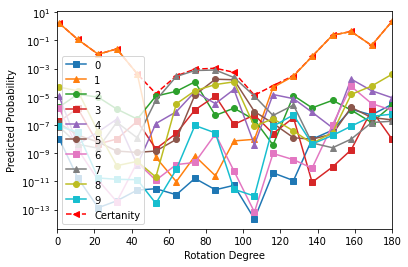

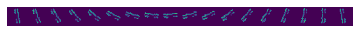

[1.684774, 0.118877426, 0.010446697, 0.025099777, 0.00042404947, 1.709822e-05, 0.00030606764, 0.00091905124, 0.0010624992, 0.00054995023, 1.3065878e-05, 6.1701656e-05, 0.0003175327, 0.0073545645, 0.23709308, 0.43235517, 0.044037566, 2.30327]


In [163]:
rotate_img_crossentropy(model2)